In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from cmcrameri import cm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

from src.Segmentation3D import *
from src.PlottingFunctions import *
from src.CellSegmentation import *
from src.HolomonitorFunctions import *

In [3]:
# experimental parameters
max_frame = 120
frames_per_hour = 4

n0 = 1.33
nd = 1.4

In [4]:
# filter parameters

# min track lenght
min_len = 30

# outlier limit
median_lim = 0.5

# accepted difference in A or h
diff_lim = 0.3

In [5]:
# choose data set
file = "A2P1"
folder = "../../data/Tomocube/MDCK_10.02.2025/"
#folder = "../../data/Holomonitor/MDCK_19.03.2024/"
#file = "A1-12"


# load data
df = pd.read_csv(f"{folder}{file}/area_volume_unfiltered.csv")

# track cells
tracks_raw = tp.link(df[df.frame < max_frame], search_range=50, memory=5)
tracks = tp.filter_stubs(tracks_raw, 5)
tracks = tracks.reset_index(drop=True)

Frame 39: 1009 trajectories present.


In [6]:
# filter out tracks shorter than min_len
particles = []
track_len = []

for p in range(max(tracks.particle)):
    particles.append(p)
    track_len.append(sum(tracks.particle==p))

particles = np.array(particles)
track_len = np.array(track_len)

long_tracks = particles[track_len >= min_len]
print(f"Number of tracks longer than {min_len/frames_per_hour:0.1f} hours:\n{len(long_tracks)}")

Number of tracks longer than 7.5 hours:
556


In [16]:
# filter out spurious tracks

good_tracks = []
for p in long_tracks:
    mask = (tracks.particle == p)

    # mask that excludes outlier points
    not_outliers = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))

    # compute change in A and h between consecutive frames
    dA = abs(np.diff(tracks[mask][not_outliers].A) / (tracks[mask][not_outliers].A[1:]))
    dh = abs(np.diff(tracks[mask][not_outliers].h_avrg) / (tracks[mask][not_outliers].h_avrg[1:]))

    # mask that excludes tracks with large changes 
    not_spurious = (dA.values <= diff_lim)*(dh.values <= diff_lim)

    # accept track if no large changes in A or h, and not too many outliers
    if np.sum(not_spurious) == len(not_spurious) and sum(not_outliers) >= min_len+5:
        good_tracks.append(p)

print(f"Number of good tracks:\n{len(good_tracks)}")

Number of good tracks:
114


In [17]:
A_decrease = [2, 5, 12, 18, 24, 20, 23, 24, 25, 30, 44, 46, 57, 59, 86, 98, 103]
A_increase = [3, 4, 9, 10, 14, 16, 17, 21, 34, 38, 39, 42, 45, 48, 50, 51, 52, 56, 60, 62, 63, 64, 65, 66, 69, 71, 72, \
               73, 75, 78, 89, 80, 83, 84, 85, 87, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 106, 107, 108, \
               109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130] # 117
A_fluct =  [1, 6, 7, 8, 11, 13, 15, 19, 22, 26, 27, 28, 29, 32, 36, 37, 40, 41, 47, 49, 53, 54, 55, 58, 61, 67, 68, 70, 74, 76, 77, 81, 82, 88, 89, 90, 93, 112, 126] # 0

plot_mask = np.concatenate([np.random.choice(A_decrease, 9, replace=False), np.random.choice(A_increase, 9, replace=False), np.random.choice(A_fluct, 9, replace=False)])
plot_mask = np.sort(plot_mask)
plot_mask

array([  2,   5,   8,  13,  14,  16,  18,  19,  20,  23,  24,  25,  26,
        32,  36,  40,  48,  51,  52,  54,  72,  75,  86,  88,  92, 103,
       108])

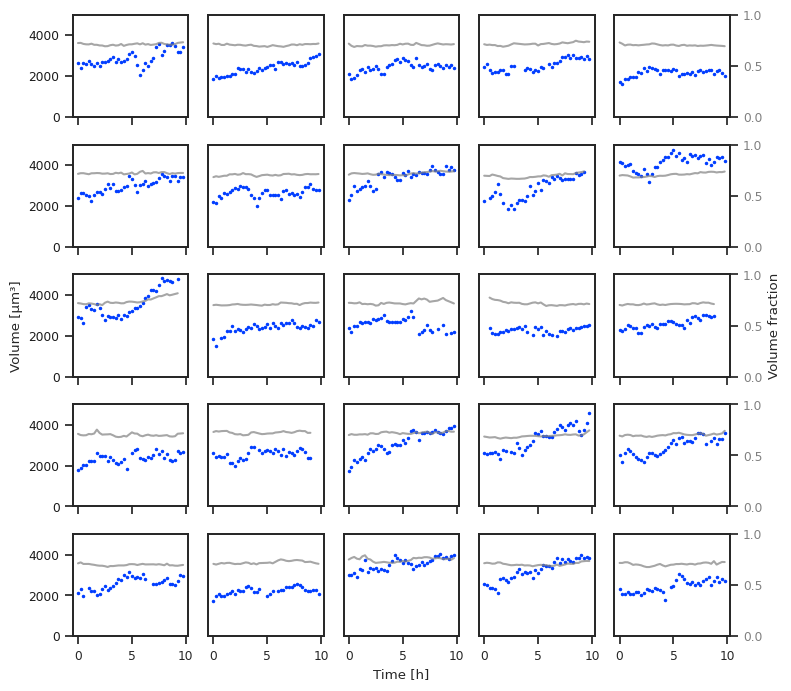

In [ ]:
sns.set_theme(style='ticks', palette='bright', font_scale=0.8)
fig, axes = plt.subplots(5,5, figsize=(8,7), sharex=True)#, sharey=True)

i = 0
for ax in axes.flatten():

    # twin axis for volume fraction
    ax1 = ax.twinx()

    # mask specific track
    mask = (tracks.particle == good_tracks[plot_mask[i]])
    
    # compute mask that avoids outliers
    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    
    # smoothen curve for visuals
    #mu = gaussian_filter(tracks[mask][outlier].V, sigma=1.5)

    # compute volume fraction
    v_frac = (tracks[mask][outlier].n_avrg - n0) / (nd - n0)
    
    # plot volume
    #ax.plot(tracks[mask][outlier].frame / 4, mu, 'r-', alpha=0.7)
    ax.plot(tracks[mask][outlier].frame / 4, (tracks[mask][outlier].V), 'b.', ms=3)

    # plot dry mass
    ax1.plot(tracks[mask][outlier].frame / 4, (v_frac), '-', color="gray", ms=2, alpha=0.7)


    # axes specifications
    if (i+1)%5 != 0:
        ax1.set_yticks([])
    else:
        ax1.set_yticks([0, .5, 1])
    if (i)%5 != 0:
        ax.set_yticks([])
    if i==14:
        ax1.set(ylabel="Volume fraction")

    ax1.set(ylim=(0,1))
    ax .set(ylim=(0, 5e3))
    ax .set_xticks([0, 5, 10])
    ax .tick_params(axis='y', labelcolor='k')
    ax1.tick_params(axis='y', labelcolor='gray')


    i += 1


axes[2,0].set(ylabel="Volume [µm³]")
axes[4,2].set(xlabel="Time [h]")
fig.tight_layout()

In [19]:
fig.savefig(f"../../figs/paper/figure5.pdf", dpi=300)

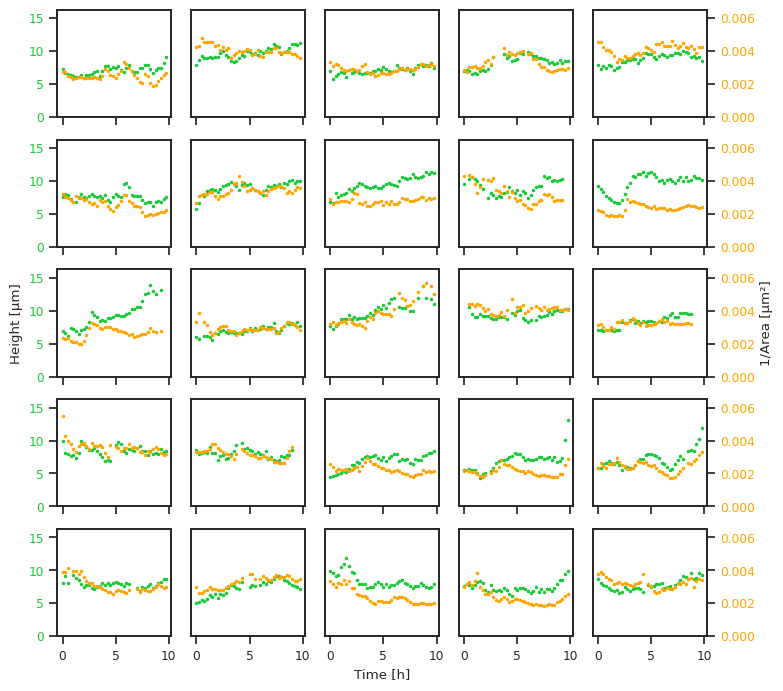

In [26]:
# figure S3
sns.set_theme(style='ticks', palette='bright', font_scale=0.8)
fig, axes = plt.subplots(5,5, figsize=(8,7), sharex=True)#, sharey=True)

i = 0
idx = 0
for ax in axes.flatten():

    # twin axis for area
    ax1 = ax.twinx()

    # mask specific track
    mask = (tracks.particle == good_tracks[plot_mask[i]])

    # compute mask that avoids outliers
    outlier = (abs(tracks[mask].V - np.median(tracks[mask].V)) <= median_lim*np.median(tracks[mask].V))
    
    # smoothen curve for visuals
    mu_h = gaussian_filter(tracks[mask][outlier].h_avrg, sigma=1.5)
    mu_A = gaussian_filter(1/tracks[mask][outlier].A,    sigma=1.5)

    # plot height
    #ax.plot(tracks[mask][outlier].frame / 4, mu_h, 'g-', alpha=0.7)
    ax.plot(tracks[mask][outlier].frame / 4, (tracks[mask][outlier].h_avrg), 'g.', ms=3)

    # plot area
    #ax1.plot(tracks[mask][outlier].frame / 4, mu_A, '-', alpha=0.7, color="orange")
    ax1.plot(tracks[mask][outlier].frame / 4, 1/(tracks[mask][outlier].A), '.', ms=3, color="orange")


    # axes specifications
    if (i+1)%5 != 0:
        ax1.set_yticks([])
    #else:
    #    ax1.set_yticks([0, .5, 1])
    if (i)%5 != 0:
        ax.set_yticks([])
    if i==14:
        ax1.set(ylabel="1/Area [µm²]")

    ax1.set(ylim=(0,0.0065))
    ax .set(ylim=(0,2500*0.0065))
    ax .set_xticks([0, 5, 10])
    ax.tick_params(axis='y', labelcolor='g')
    ax1.tick_params(axis='y', labelcolor='orange')



    i += 1

axes[2,0].set(ylabel="Height [µm]")
axes[4,2].set(xlabel="Time [h]")
fig.tight_layout()

In [25]:
fig.savefig(f"../../figs/paper/figureS3.pdf", dpi=300)